# Notebook 40 — Commodity Volatility & Seasonality (Energy)

This notebook provides **descriptive diagnostics** of WTI volatility regimes and calendar seasonality. It is **not** a forecasting or trading model.

**Data source:** processed files generated by `scripts/pull_commodity_data.py`.

Focus:
- Identify regime shifts in realized volatility.
- Compare tail behavior across regimes.
- Examine seasonality and its interaction with regime definitions.
- Link empirical regime effects back to Monte Carlo inputs.


**Reading guide**

1. Validate data integrity and baseline return properties.
2. Define volatility regimes and compare static vs expanding thresholds.
3. Quantify tail behavior within regimes.
4. Diagnose seasonality and test for regime confounding.
5. Translate regimes into Monte Carlo `sigma` scenarios.

Figures are saved under `figures/40_commodity_vol_and_seasonality/` with stable filenames.


In [ ]:
# Parameters
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data/processed"
DAILY_PATH = DATA_DIR / "wti_daily.csv"
DAILY_FEATURES_PATH = DATA_DIR / "wti_features_daily.csv"
MONTHLY_PATH = DATA_DIR / "wti_monthly.csv"
MONTHLY_FEATURES_PATH = DATA_DIR / "wti_features_monthly.csv"

FIG_DIR = PROJECT_ROOT / "figures/40_commodity_vol_and_seasonality"

DATE_START = "2000-01-01"
DATE_END = None  # or "2025-12-31"

# Regime thresholds
STATIC_Q_LOW = 0.33
STATIC_Q_HIGH = 0.66
EXPANDING_MIN_PERIODS = 60  # uses vol_60d

# Monte Carlo parameters
S0 = 100.0
r = 0.02
T = 1.0
n_steps = 252
n_paths = 50_000
seed = 7
alpha = 0.05  # tail probability for VaR/ES

In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy import stats

from typing import TYPE_CHECKING


PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

simulate_gbm_paths = importlib.import_module("src.gbm").simulate_gbm_paths

sns.set_theme(style="whitegrid")

if TYPE_CHECKING:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path
    from scipy import stats
    from src.gbm import simulate_gbm_paths

    daily: pd.DataFrame
    daily_features: pd.DataFrame
    monthly: pd.DataFrame
    monthly_features: pd.DataFrame
    vol: pd.DataFrame
    regime_colors: dict
    FIG_DIR: Path

    STATIC_Q_LOW: float
    STATIC_Q_HIGH: float
    EXPANDING_MIN_PERIODS: int
    S0: float
    r: float
    T: float
    n_steps: int
    n_paths: int
    seed: int
    alpha: float
FIG_DIR.mkdir(parents=True, exist_ok=True)


def _date_filter(df: pd.DataFrame, start: str | None, end: str | None) -> pd.DataFrame:
    data = df.copy()
    if start:
        data = data[data["date"] >= pd.Timestamp(start)]
    if end:
        data = data[data["date"] <= pd.Timestamp(end)]
    return data

## 1) Setup & data integrity

We load the preprocessed dataset and run basic checks (date ordering, missing values, simple return sanity). This ensures that later diagnostics reflect the data rather than pipeline issues.


**Why this step matters**

Commodity data often contain rolling contract effects and missing observations. Basic integrity checks help ensure that later regime labels are not driven by data artifacts.


In [12]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_DIR = PROJECT_ROOT / "data/processed"
DAILY_PATH = DATA_DIR / "wti_daily.csv"
DAILY_FEATURES_PATH = DATA_DIR / "wti_features_daily.csv"
MONTHLY_PATH = DATA_DIR / "wti_monthly.csv"
MONTHLY_FEATURES_PATH = DATA_DIR / "wti_features_monthly.csv"

for path in [DAILY_PATH, DAILY_FEATURES_PATH, MONTHLY_PATH, MONTHLY_FEATURES_PATH]:
    if not path.exists():
        raise FileNotFoundError(
            f"Missing {path}. Run: python scripts/pull_commodity_data.py --start 2000-01-01"
        )

daily = pd.read_csv(DAILY_PATH, parse_dates=["date"])
daily_features = pd.read_csv(DAILY_FEATURES_PATH, parse_dates=["date"])
monthly = pd.read_csv(MONTHLY_PATH, parse_dates=["date"])
monthly_features = pd.read_csv(MONTHLY_FEATURES_PATH, parse_dates=["date"])

expected_daily_cols = {"date", "price"}
expected_daily_features = {
    "date",
    "price",
    "ret_1d",
    "vol_20d",
    "vol_60d",
    "vol_252d",
    "month",
    "day_of_week",
    "vol_regime",
}
expected_monthly_cols = {"date", "price", "ret_1m"}
expected_monthly_features = {
    "date",
    "price",
    "ret_1m",
    "vol_3m",
    "vol_12m",
    "month",
    "quarter",
}

assert expected_daily_cols.issubset(daily.columns)
assert expected_daily_features.issubset(daily_features.columns)
assert expected_monthly_cols.issubset(monthly.columns)
assert expected_monthly_features.issubset(monthly_features.columns)

for name, df in {
    "daily": daily,
    "daily_features": daily_features,
    "monthly": monthly,
    "monthly_features": monthly_features,
}.items():
    assert df["date"].is_monotonic_increasing, f"{name} dates not sorted"
    assert df["date"].is_unique, f"{name} dates not unique"

daily = _date_filter(daily, DATE_START, DATE_END)
daily_features = _date_filter(daily_features, DATE_START, DATE_END)
monthly = _date_filter(monthly, DATE_START, DATE_END)
monthly_features = _date_filter(monthly_features, DATE_START, DATE_END)

print(
    f"Daily features: {daily_features['date'].min().date()} to {daily_features['date'].max().date()}"
)
print(f"Daily observations: {len(daily_features):,}")
print(
    f"Monthly features: {monthly_features['date'].min().date()} to {monthly_features['date'].max().date()}"
)
print(f"Monthly observations: {len(monthly_features):,}")

Daily features: 2000-01-04 to 2026-01-26
Daily observations: 6,535
Monthly features: 2000-01-31 to 2026-01-31
Monthly observations: 313


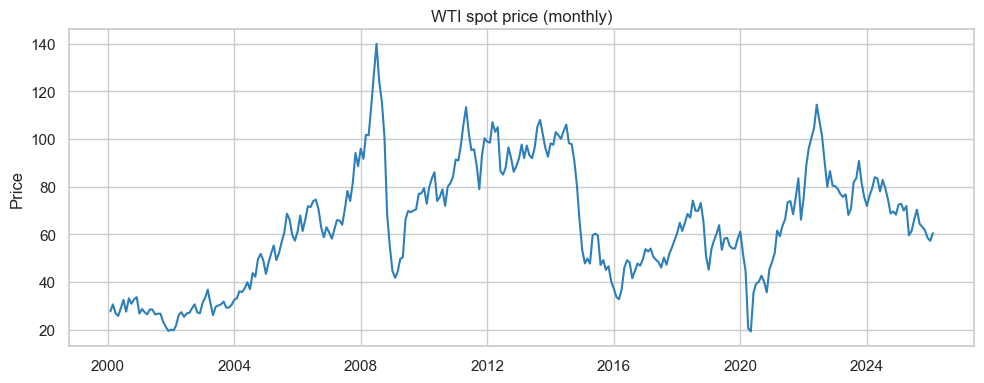

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly["date"], monthly["price"], color="#2c7fb8", lw=1.5)
ax.set_title("WTI spot price (monthly)")
ax.set_ylabel("Price")
fig.tight_layout()
fig.savefig(FIG_DIR / "price_timeseries.png", dpi=150)
plt.show()
plt.close(fig)

## 2) Volatility regimes (static vs expanding)

We define volatility regimes using rolling realized volatility and compare:
- **Static thresholds** (fixed cutoffs over the full sample)
- **Expanding thresholds** (cutoffs that evolve through time)

This helps separate genuine regime effects from look-ahead artifacts.


**Interpretation tip**

If expanding thresholds differ materially from static thresholds, the regime classification is sensitive to sample growth—highlighting why look-ahead bias can matter in regime studies.


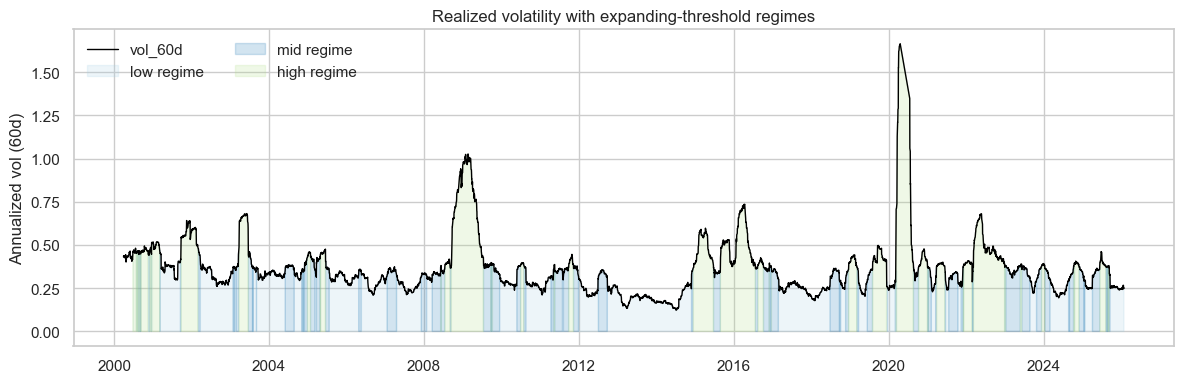

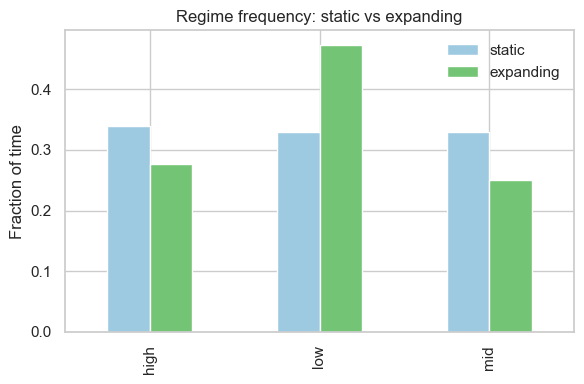

In [14]:
vol = daily_features[["date", "vol_60d"]].copy()
vol = vol.dropna(subset=["vol_60d"]).reset_index(drop=True)

q_low_static = vol["vol_60d"].quantile(STATIC_Q_LOW)
q_high_static = vol["vol_60d"].quantile(STATIC_Q_HIGH)


def label_regime(series: pd.Series, q_low: pd.Series, q_high: pd.Series) -> pd.Series:
    conditions = [series < q_low, series < q_high]
    choices = ["low", "mid"]
    out = np.select(conditions, choices, default="high")
    out = pd.Series(out, index=series.index, dtype="object")
    out[series.isna() | q_low.isna() | q_high.isna()] = np.nan
    return out


vol["regime_static"] = label_regime(
    vol["vol_60d"],
    pd.Series(q_low_static, index=vol.index),
    pd.Series(q_high_static, index=vol.index),
)

q_low_exp = vol["vol_60d"].expanding(min_periods=EXPANDING_MIN_PERIODS).quantile(STATIC_Q_LOW)
q_high_exp = vol["vol_60d"].expanding(min_periods=EXPANDING_MIN_PERIODS).quantile(STATIC_Q_HIGH)
vol["regime_expanding"] = label_regime(vol["vol_60d"], q_low_exp, q_high_exp)

regime_colors = {"low": "#a6cee3", "mid": "#1f78b4", "high": "#b2df8a"}

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(vol["date"], vol["vol_60d"], color="black", lw=1.0, label="vol_60d")
for regime, color in regime_colors.items():
    mask = vol["regime_expanding"] == regime
    ax.fill_between(
        vol["date"],
        0,
        vol["vol_60d"],
        where=mask,
        color=color,
        alpha=0.2,
        label=f"{regime} regime",
    )
ax.set_title("Realized volatility with expanding-threshold regimes")
ax.set_ylabel("Annualized vol (60d)")
ax.legend(ncols=2, frameon=False)
fig.tight_layout()
fig.savefig(FIG_DIR / "rolling_vol_regimes_expanding.png", dpi=150)
plt.show()
plt.close(fig)

static_freq = vol["regime_static"].value_counts(normalize=True).rename("static").sort_index()
expanding_freq = (
    vol["regime_expanding"].value_counts(normalize=True).rename("expanding").sort_index()
)
regime_compare = pd.concat([static_freq, expanding_freq], axis=1).fillna(0.0)

fig, ax = plt.subplots(figsize=(6, 4))
regime_compare.plot(kind="bar", ax=ax, color=["#9ecae1", "#74c476"])
ax.set_ylabel("Fraction of time")
ax.set_title("Regime frequency: static vs expanding")
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(FIG_DIR / "regime_static_vs_expanding_comparison.png", dpi=150)
plt.show()
plt.close(fig)

daily_features = daily_features.merge(
    vol[["date", "regime_expanding"]], on="date", how="left"
).rename(columns={"regime_expanding": "regime"})

## 3) Returns and tail behavior by regime

We examine return distributions and tail metrics within each volatility regime.

Interpretation:
- High-vol regimes should show fatter tails and larger downside moves.
- Differences across regimes illustrate why a single-volatility model can understate risk during turbulent periods.


**What to look for**

Heavier tails in high-vol regimes imply that a single-volatility GBM baseline can understate tail risk during stressed periods.


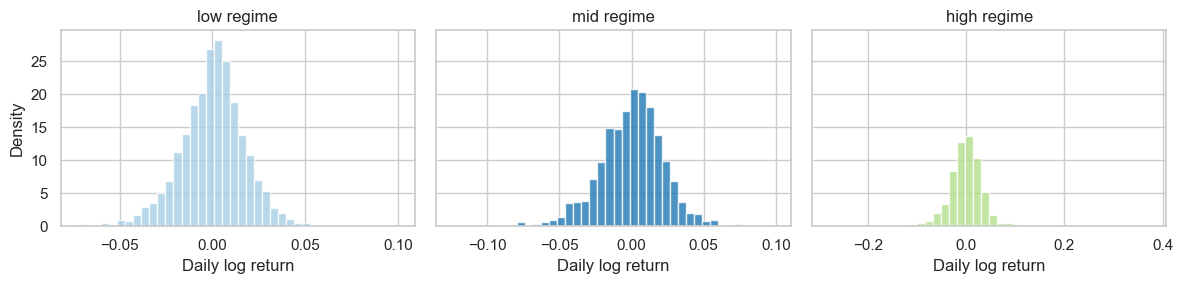

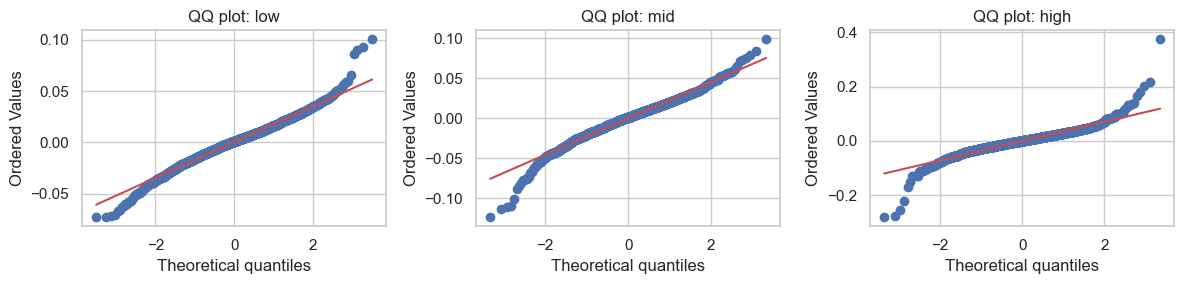

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, regime in zip(axes, ["low", "mid", "high"]):
    subset = daily_features.loc[daily_features["regime"] == regime, "ret_1d"].dropna()
    ax.hist(subset, bins=40, color=regime_colors[regime], alpha=0.8, density=True)
    ax.set_title(f"{regime} regime")
    ax.set_xlabel("Daily log return")
axes[0].set_ylabel("Density")
fig.tight_layout()
fig.savefig(FIG_DIR / "returns_hist_by_regime.png", dpi=150)
plt.show()
plt.close(fig)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, regime in zip(axes, ["low", "mid", "high"]):
    subset = daily_features.loc[daily_features["regime"] == regime, "ret_1d"].dropna()
    stats.probplot(subset, dist="norm", plot=ax)
    ax.set_title(f"QQ plot: {regime}")
fig.tight_layout()
fig.savefig(FIG_DIR / "qqplot_returns_vs_normal.png", dpi=150)
plt.show()
plt.close(fig)

## 4) Seasonality diagnostics

We compute monthly statistics to identify calendar seasonality. We then check whether seasonality persists after conditioning on volatility regimes.

This distinguishes **true calendar effects** from **regime confounding**.


**Seasonality caveat**

If seasonality weakens after conditioning on regime, the apparent calendar effect may be a byproduct of regime clustering rather than a stable seasonal pattern.


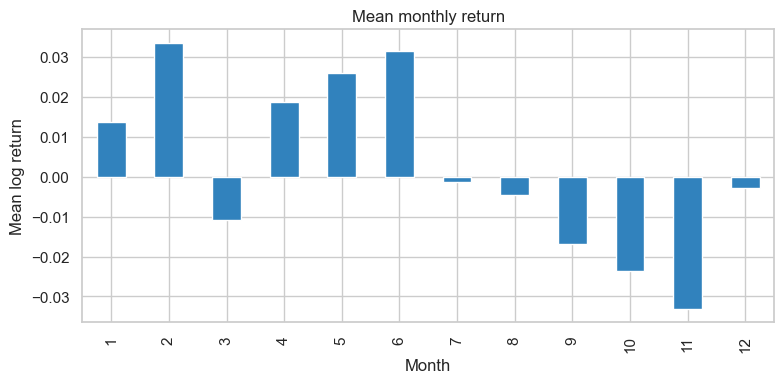

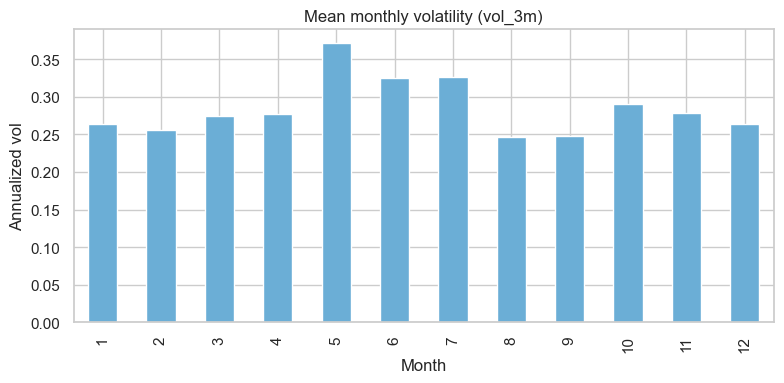

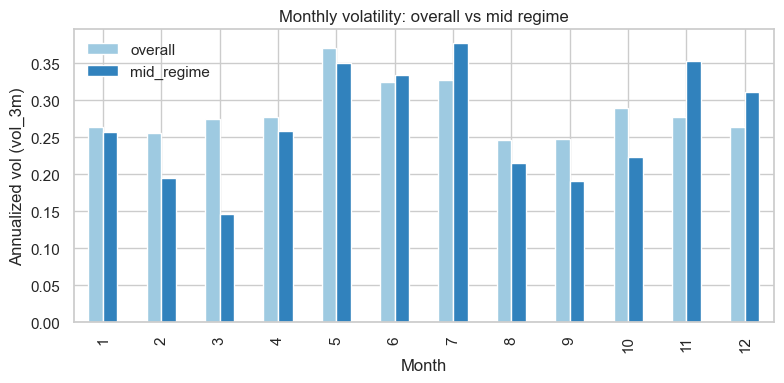

In [16]:
monthly_returns_by_month = monthly.groupby(monthly["date"].dt.month)["ret_1m"].mean()
monthly_vol_by_month = monthly_features.groupby("month")["vol_3m"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
monthly_returns_by_month.plot(kind="bar", ax=ax, color="#3182bd")
ax.set_title("Mean monthly return")
ax.set_xlabel("Month")
ax.set_ylabel("Mean log return")
fig.tight_layout()
fig.savefig(FIG_DIR / "seasonality_monthly_return.png", dpi=150)
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(8, 4))
monthly_vol_by_month.plot(kind="bar", ax=ax, color="#6baed6")
ax.set_title("Mean monthly volatility (vol_3m)")
ax.set_xlabel("Month")
ax.set_ylabel("Annualized vol")
fig.tight_layout()
fig.savefig(FIG_DIR / "seasonality_monthly_vol.png", dpi=150)
plt.show()
plt.close(fig)

daily_regime = daily_features[["date", "regime"]].dropna(subset=["regime"]).sort_values("date")
monthly_with_regime = pd.merge_asof(
    monthly_features.sort_values("date"),
    daily_regime,
    on="date",
    direction="backward",
)

overall = monthly_with_regime.groupby("month")["vol_3m"].mean()
mid_only = (
    monthly_with_regime.loc[monthly_with_regime["regime"] == "mid"]
    .groupby("month")["vol_3m"]
    .mean()
)
seasonality_compare = pd.DataFrame({"overall": overall, "mid_regime": mid_only})

fig, ax = plt.subplots(figsize=(8, 4))
seasonality_compare.plot(kind="bar", ax=ax, color=["#9ecae1", "#3182bd"])
ax.set_title("Monthly volatility: overall vs mid regime")
ax.set_xlabel("Month")
ax.set_ylabel("Annualized vol (vol_3m)")
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(FIG_DIR / "seasonality_monthly_vol_by_regime.png", dpi=150)
plt.show()
plt.close(fig)

## 5) Link to Monte Carlo engine: regime-dependent σ scenarios

We translate empirical regime volatility into a small set of `sigma` scenarios.

These scenarios can be fed into the Monte Carlo engine to show how regime changes map into risk metrics (VaR/ES) or pricing dispersion.


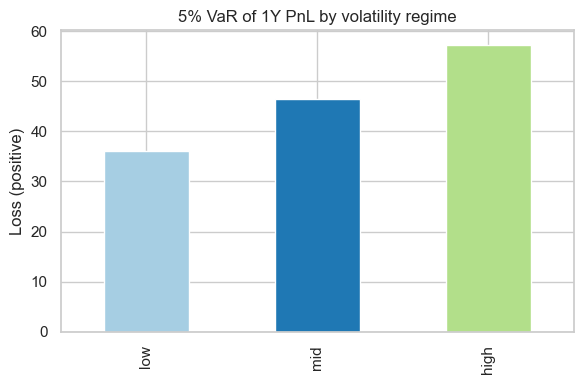

In [17]:
regime_sigmas = (
    daily_features.dropna(subset=["vol_60d", "regime"]).groupby("regime")["vol_60d"].median()
)
sigma_low = float(regime_sigmas.loc["low"])
sigma_mid = float(regime_sigmas.loc["mid"])
sigma_high = float(regime_sigmas.loc["high"])


def simulate_pnl(sigma: float) -> pd.Series:
    _, paths = simulate_gbm_paths(
        S0=S0,
        mu=r,
        sigma=sigma,
        T=T,
        n_steps=n_steps,
        n_paths=n_paths,
        seed=seed,
    )
    S_T = paths[:, -1]
    pnl = S_T - S0
    return pd.Series(pnl)


results = {}
for label, sigma in {
    "low": sigma_low,
    "mid": sigma_mid,
    "high": sigma_high,
}.items():
    pnl = simulate_pnl(sigma)
    var = -pnl.quantile(alpha)
    es = -pnl[pnl <= pnl.quantile(alpha)].mean()
    results[label] = {"sigma": sigma, "VaR_5": var, "ES_5": es}

results_df = pd.DataFrame(results).T

fig, ax = plt.subplots(figsize=(6, 4))
results_df["VaR_5"].plot(kind="bar", ax=ax, color=["#a6cee3", "#1f78b4", "#b2df8a"])
ax.set_title("5% VaR of 1Y PnL by volatility regime")
ax.set_ylabel("Loss (positive)")
fig.tight_layout()
fig.savefig(FIG_DIR / "mc_outputs_by_regime.png", dpi=150)
plt.show()
plt.close(fig)

## 6) Optional: rolling sigma proxy

This optional section builds a smooth rolling volatility proxy to visualize how model inputs might evolve through time.

This is a diagnostic view only; it is **not** a forecasting rule.


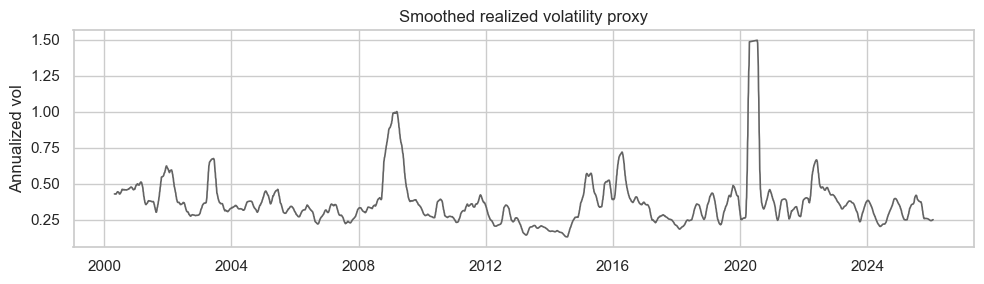

In [18]:
sigma_model = vol.set_index("date")["vol_60d"].rolling(20).mean()
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(sigma_model.index, sigma_model.values, color="#636363", lw=1.2)
ax.set_title("Smoothed realized volatility proxy")
ax.set_ylabel("Annualized vol")
fig.tight_layout()
fig.savefig(FIG_DIR / "sigma_model_timeseries.png", dpi=150)
plt.show()
plt.close(fig)

## 7) Interpretation & limitations

Key takeaways:
- Volatility regimes show distinct tail behavior; high-vol regimes exhibit heavier tails.
- Monthly seasonality patterns weaken when conditioning on mid-vol regimes, suggesting regime confounding.
- Regime-dependent `sigma` materially changes Monte Carlo risk outputs.

Limitations:
- Single series and simple regime definition.
- GBM is a reference model, not a structural commodity model.
- This is descriptive and diagnostic — **not predictive**.
